In [ ]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import mean_squared_error
from sklearn.metrics import mean_squared_error, mean_absolute_error


In [ ]:
from google.colab import drive
drive.mount('/content/drive/')

Mounted at /content/drive/


In [ ]:
data_path = '/content/drive/My Drive/자치구_학교별_입학자.xlsx'

In [ ]:
data = pd.read_excel(data_path)
# '학교명' 열을 제외하고 데이터 집계
data_aggregated = data.drop('학교명', axis=1).groupby('자치구').sum().transpose()

# 인덱스를 연도로 변환
data_aggregated.index = [int(col.split('_')[-1]) for col in data_aggregated.index]

In [ ]:
# 데이터 스케일링
scaler = MinMaxScaler(feature_range=(0, 1))
scaled_data = scaler.fit_transform(data_aggregated)

In [ ]:
# 데이터를 시퀀스로 변환하는 함수
def create_dataset(dataset, look_back=1):
    dataX, dataY = [], []
    for i in range(len(dataset) - look_back):
        a = dataset[i:(i + look_back), :]
        dataX.append(a)
        dataY.append(dataset[i + look_back, :])
    return np.array(dataX), np.array(dataY)


In [ ]:
# 모델 입력 데이터 준비
look_back = 3
trainX, trainY = create_dataset(scaled_data, look_back)

In [ ]:
# 모델 설계
model = Sequential([
    LSTM(50, input_shape=(look_back, data_aggregated.shape[1])),
    Dense(data_aggregated.shape[1])
])

In [ ]:
# 모델 컴파일
model.compile(optimizer='adam', loss='mean_squared_error')

In [ ]:
# 모델 훈련
model.fit(trainX, trainY, epochs=100, batch_size=1, verbose=2)

Epoch 1/100
13/13 - 2s - loss: 0.1445 - 2s/epoch - 166ms/step
Epoch 2/100
13/13 - 0s - loss: 0.0666 - 41ms/epoch - 3ms/step
Epoch 3/100
13/13 - 0s - loss: 0.0408 - 41ms/epoch - 3ms/step
Epoch 4/100
13/13 - 0s - loss: 0.0314 - 37ms/epoch - 3ms/step
Epoch 5/100
13/13 - 0s - loss: 0.0287 - 39ms/epoch - 3ms/step
Epoch 6/100
13/13 - 0s - loss: 0.0270 - 33ms/epoch - 3ms/step
Epoch 7/100
13/13 - 0s - loss: 0.0271 - 40ms/epoch - 3ms/step
Epoch 8/100
13/13 - 0s - loss: 0.0249 - 35ms/epoch - 3ms/step
Epoch 9/100
13/13 - 0s - loss: 0.0244 - 34ms/epoch - 3ms/step
Epoch 10/100
13/13 - 0s - loss: 0.0230 - 35ms/epoch - 3ms/step
Epoch 11/100
13/13 - 0s - loss: 0.0224 - 34ms/epoch - 3ms/step
Epoch 12/100
13/13 - 0s - loss: 0.0210 - 35ms/epoch - 3ms/step
Epoch 13/100
13/13 - 0s - loss: 0.0200 - 39ms/epoch - 3ms/step
Epoch 14/100
13/13 - 0s - loss: 0.0193 - 37ms/epoch - 3ms/step
Epoch 15/100
13/13 - 0s - loss: 0.0189 - 53ms/epoch - 4ms/step
Epoch 16/100
13/13 - 0s - loss: 0.0188 - 56ms/epoch - 4ms/step
E

In [ ]:
import matplotlib.font_manager as fm  # 폰트 관리


!apt-get update -qq         # apt-get 패키지 설치 명령어, -qq : 에러외 메세지 숨기기
!apt-get install fonts-nanum* -qq #나눔글꼴 설치

fe = fm.FontEntry(fname=r'/usr/share/fonts/truetype/nanum/NanumGothic.ttf', name='NanumGothic') #파일 저장되어있는 경로와 이름 설정
fm.fontManager.ttflist.insert(0, fe)  # Matplotlib에 폰트 추가
plt.rcParams.update({'font.size': 10, 'font.family': 'NanumGothic'}) #폰트설정

Selecting previously unselected package fonts-nanum.
(Reading database ... 121913 files and directories currently installed.)
Preparing to unpack .../fonts-nanum_20200506-1_all.deb ...
Unpacking fonts-nanum (20200506-1) ...
Selecting previously unselected package fonts-nanum-coding.
Preparing to unpack .../fonts-nanum-coding_2.5-3_all.deb ...
Unpacking fonts-nanum-coding (2.5-3) ...
Selecting previously unselected package fonts-nanum-eco.
Preparing to unpack .../fonts-nanum-eco_1.000-7_all.deb ...
Unpacking fonts-nanum-eco (1.000-7) ...
Selecting previously unselected package fonts-nanum-extra.
Preparing to unpack .../fonts-nanum-extra_20200506-1_all.deb ...
Unpacking fonts-nanum-extra (20200506-1) ...
Setting up fonts-nanum-extra (20200506-1) ...
Setting up fonts-nanum (20200506-1) ...
Setting up fonts-nanum-coding (2.5-3) ...
Setting up fonts-nanum-eco (1.000-7) ...
Processing triggers for fontconfig (2.13.1-4.2ubuntu5) ...


1/1 [==============================] - 2s 2s/step


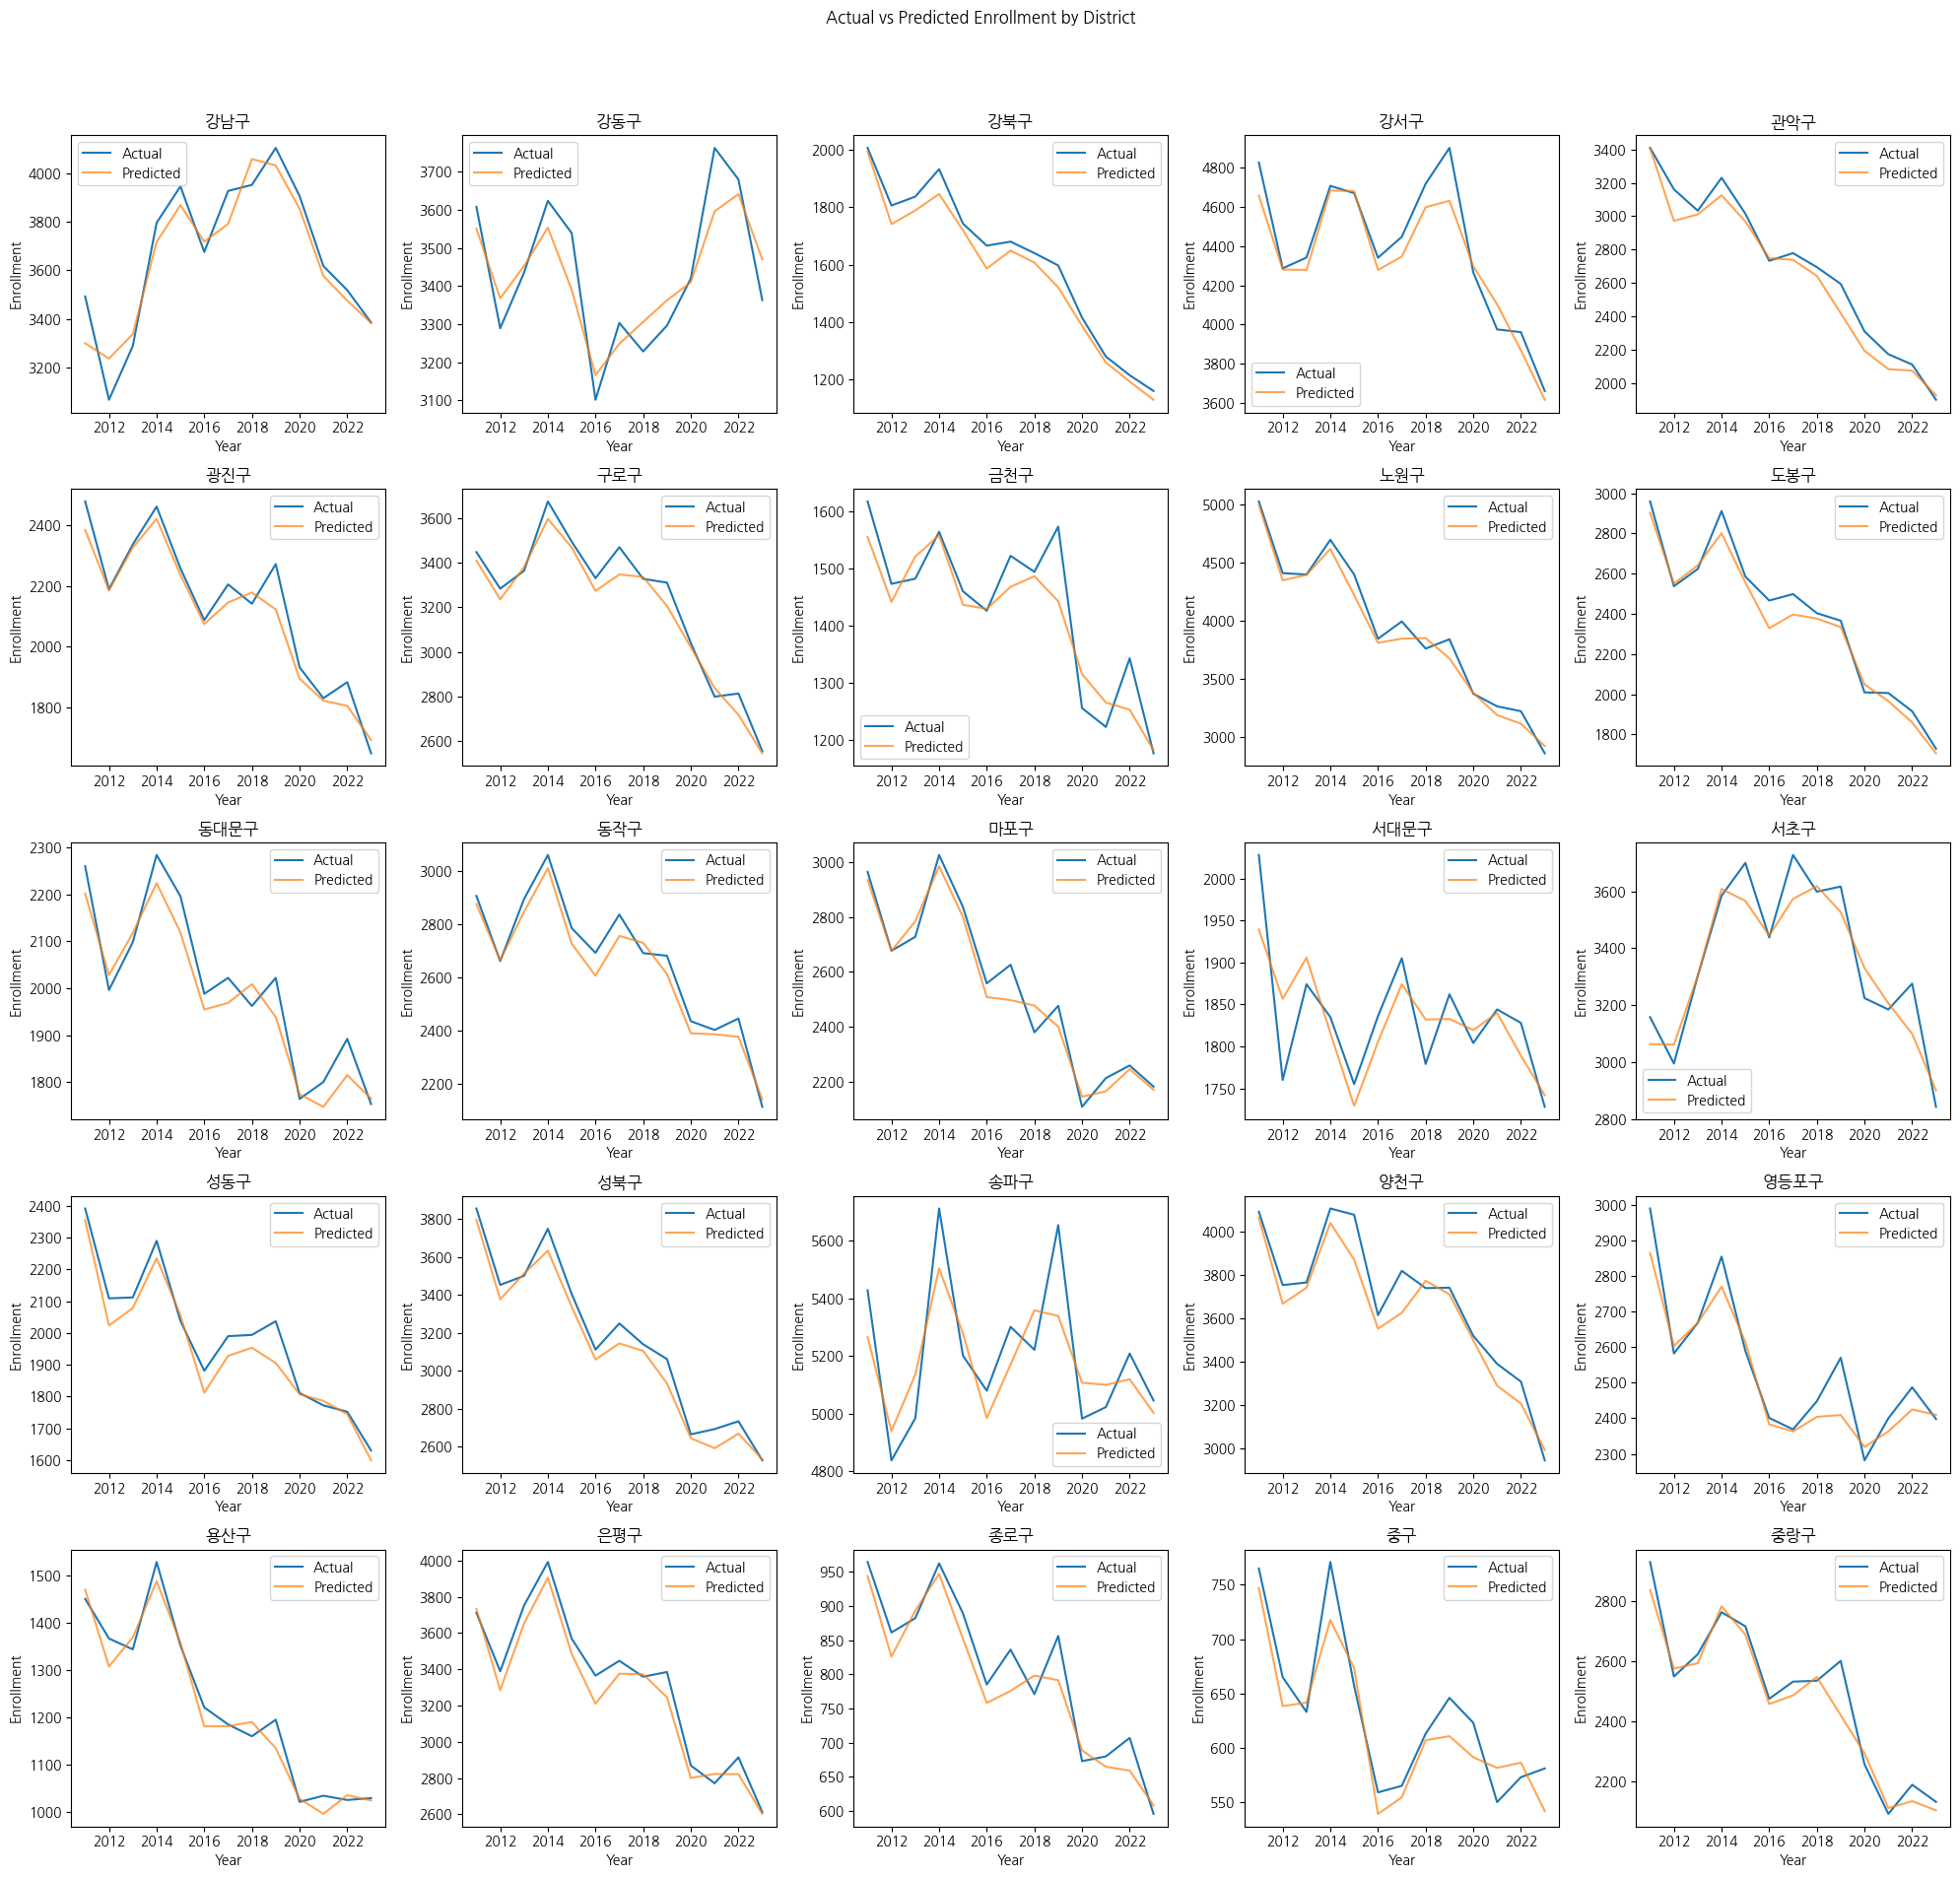

In [ ]:
# 모델 예측
testPredict = model.predict(trainX)

# 스케일된 데이터를 원래 스케일로 변환
testPredict = scaler.inverse_transform(testPredict)
actual_values = scaler.inverse_transform(scaled_data[look_back:])

# 결과 시각화
fig, axes = plt.subplots(nrows=5, ncols=5, figsize=(20, 20))  # 25개 자치구에 맞춰 조정
fig.suptitle('Actual vs Predicted Enrollment by District')

districts = data_aggregated.columns  # 자치구 이름

for i, district in enumerate(districts):
    ax = axes[i // 5, i % 5]
    ax.plot(data_aggregated.index[look_back:], actual_values[:, i], label='Actual')
    ax.plot(data_aggregated.index[look_back:], testPredict[:, i], label='Predicted', alpha=0.7)
    ax.set_title(district)
    ax.set_xlabel('Year')
    ax.set_ylabel('Enrollment')
    ax.legend()

plt.tight_layout(rect=[0, 0.03, 1, 0.95])
plt.show()

In [ ]:
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score
# 성능 평가 지표 계산
mse = mean_squared_error(actual_values, testPredict)
rmse = np.sqrt(mse)
mae = mean_absolute_error(actual_values, testPredict)
r2 = r2_score(actual_values, testPredict)

# 성능 지표 출력
print("Mean Squared Error:", mse)
print("Root Mean Squared Error:", rmse)
print("Mean Absolute Error:", mae)
print("R-squared:", r2)

Mean Squared Error: 5745.172525428636
Root Mean Squared Error: 75.79691633192365
Mean Absolute Error: 58.03080397385816
R-squared: 0.8969471240171708


In [ ]:
# 미래 데이터 예측을 위한 데이터 준비
last_data = scaled_data[-look_back:]
last_data = last_data.reshape(1, look_back, data_aggregated.shape[1])

# 예측
future_steps = 10
predictions = model.predict(last_data)
for _ in range(future_steps-1):
    # 차원을 맞추기 위해 reshape을 사용
    next_input = predictions[-1:].reshape(1, 1, data_aggregated.shape[1])
    last_data = np.append(last_data[:, 1:, :], next_input, axis=1)
    predictions = np.append(predictions, model.predict(last_data), axis=0)

# 예측된 데이터를 원래 스케일로 변환
predicted_data = scaler.inverse_transform(predictions)
predicted_years = list(range(2024, 2024 + future_steps))
predicted_df = pd.DataFrame(predicted_data, index=predicted_years, columns=data_aggregated.columns)

# 결과 출력
print(predicted_df)


1/1 [==============================] - 0s 58ms/step
자치구           강남구          강동구          강북구          강서구          관악구  \
2024  3234.349609  3412.628174  1151.150269  3566.437500  1879.475098   
2025  3236.347168  3398.678711  1192.687378  3638.199707  1931.720947   
2026  3199.527344  3302.905273  1198.334351  3646.112305  1909.934448   
2027  3188.409668  3283.624268  1187.505737  3661.457520  1900.869019   
2028  3199.576172  3309.418945  1202.481079  3714.542969  1925.384033   
2029  3206.412598  3316.351318  1212.069580  3742.373535  1937.756958   
2030  3214.004639  3328.581787  1217.522095  3754.219482  1944.251099   
2031  3223.060547  3348.398682  1225.319458  3766.423096  1956.820557   
2032  3230.745117  3360.864502  1232.280762  3773.418701  1968.482910   
2033  3237.586914  3370.050293  1237.584595  3776.979248  1978.415283   

자치구           광진구          구로구          금천구          노원구          도봉구  ...  \
2024  1620.832031  2512.737549  1141.848633  2739.423584  1685.273

In [ ]:
import pandas as pd
import numpy as np
from sklearn.preprocessing import MinMaxScaler
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense
from sklearn.metrics import mean_squared_error

# 파일 로드
data_path = '/content/drive/My Drive/자치구_학교별_입학자.xlsx'
data = pd.read_excel(data_path)

# 데이터 long format 변환
data_long = data.melt(id_vars=['자치구', '학교명'], var_name='연도', value_name='입학자수')
data_long['연도'] = data_long['연도'].str.extract('(\d+)').astype(int)

# 각 학교별로 모델 훈련 및 결과 저장
results = []
scaler = MinMaxScaler(feature_range=(0, 1))

for (district, school), group in data_long.groupby(['자치구', '학교명']):
    series = group.sort_values('연도')['입학자수'].values.reshape(-1, 1)
    scaled_series = scaler.fit_transform(series)

    def create_dataset(dataset, look_back=1):
        dataX, dataY = [], []
        for i in range(len(dataset) - look_back):
            a = dataset[i:(i + look_back), 0]
            dataX.append(a)
            dataY.append(dataset[i + look_back, 0])
        return np.array(dataX), np.array(dataY)

    look_back = 3
    trainX, trainY = create_dataset(scaled_series, look_back)
    trainX = np.reshape(trainX, (trainX.shape[0], trainX.shape[1], 1))

    model = Sequential([
        LSTM(10, input_shape=(look_back, 1)),
        Dense(1)
    ])
    model.compile(loss='mean_squared_error', optimizer='adam')
    model.fit(trainX, trainY, epochs=50, batch_size=1, verbose=0)

    last_values = scaled_series[-look_back:].reshape(1, look_back, 1)
    prediction = model.predict(last_values)
    original = scaler.inverse_transform(prediction)[0][0]

    results.append((district, school, original))

results_df = pd.DataFrame(results, columns=['자치구', '학교명', '예측된 입학자수'])



1/1 [==============================] - 0s 437ms/step


1/1 [==============================] - 0s 490ms/step


1/1 [==============================] - 0s 444ms/step


In [ ]:
# 데이터 프레임을 Excel 파일로 저장
excel_filename = '/content/RNN 입학생수_자치구_학교.xlsx'
predicted_df.to_excel(excel_filename)

# 생성된 파일을 다운로드
from google.colab import files
files.download(excel_filename)


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

In [ ]:
import matplotlib.font_manager as fm  # 폰트 관리


!apt-get update -qq         # apt-get 패키지 설치 명령어, -qq : 에러외 메세지 숨기기
!apt-get install fonts-nanum* -qq #나눔글꼴 설치

fe = fm.FontEntry(fname=r'/usr/share/fonts/truetype/nanum/NanumGothic.ttf', name='NanumGothic') #파일 저장되어있는 경로와 이름 설정
fm.fontManager.ttflist.insert(0, fe)  # Matplotlib에 폰트 추가
plt.rcParams.update({'font.size': 10, 'font.family': 'NanumGothic'}) #폰트설정

- 현재 데이터를 기반으로 2033년의 예측값 계산: 계산된 예측값을 사용

- 각 자치구별로 예측된 입학자 수 합계 계산: 2033년에 대한 예측된 입학자 수를 자치구별로 집계

- 각 자치구의 현재 입학자 수와 비교: 가장 최근 데이터(2023년)와 2033년의 예측된 입학자 수를 비교하여 감소율을 계산?

- 감소율을 시각화

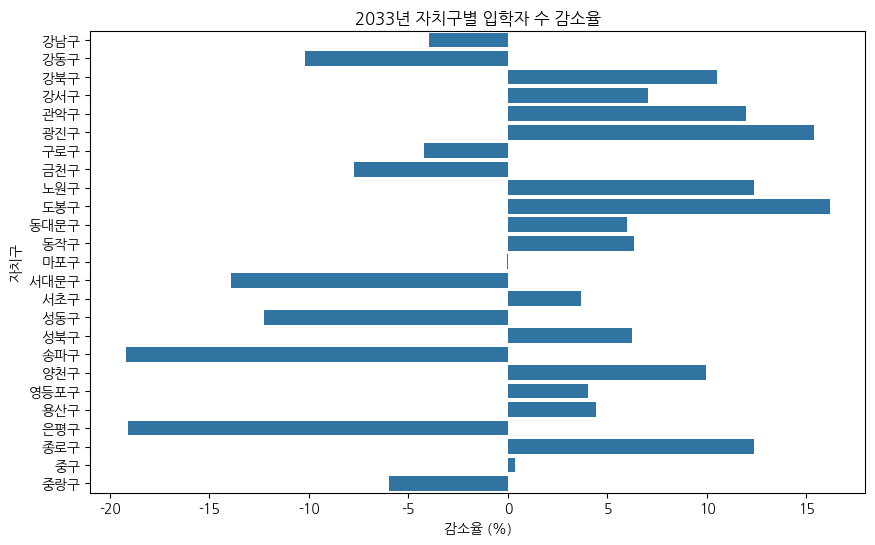

2033년 가장 큰 입학자 수 감소율을 보이는 자치구는 송파구입니다.


In [ ]:
# 2023년 자치구별 입학자 수 집계
latest_year_data = data_long[data_long['연도'] == 2023].groupby('자치구')['입학자수'].sum()

# 2033년 자치구별 예측된 입학자 수 집계
future_data_2033 = results_df.groupby('자치구')['예측된 입학자수'].sum()

# 감소율 계산
decrease_rate_2033 = (future_data_2033 - latest_year_data) / latest_year_data * 100

# 감소율 데이터 프레임 생성
decrease_rate_2033_df = pd.DataFrame(decrease_rate_2033, columns=['감소율'])

plt.rcParams['axes.unicode_minus'] = False

# 시각화
plt.figure(figsize=(10, 6))
sns.barplot(x=decrease_rate_2033_df['감소율'], y=decrease_rate_2033_df.index)
plt.title('2033년 자치구별 입학자 수 감소율')
plt.xlabel('감소율 (%)')
plt.ylabel('자치구')
plt.show()

# 가장 큰 감소율을 가진 자치구 출력
max_decrease_district = decrease_rate_2033_df['감소율'].idxmin()
print(f"2033년 가장 큰 입학자 수 감소율을 보이는 자치구는 {max_decrease_district}입니다.")


/usr/local/lib/python3.10/dist-packages/IPython/core/pylabtools.py:151: UserWarning: Glyph 8722 (\N{MINUS SIGN}) missing from current font.
  fig.canvas.print_figure(bytes_io, **kw)


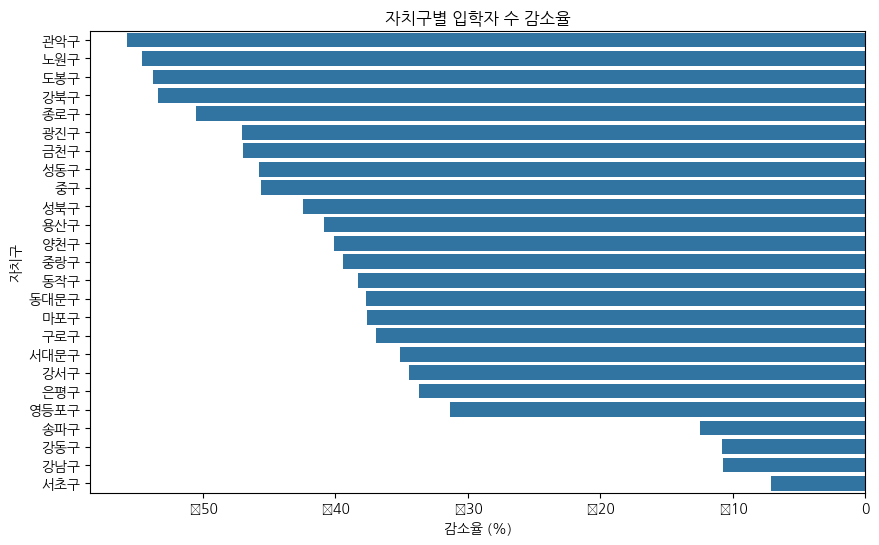

In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.cluster import KMeans

# 데이터 로드 및 전처리
data_path = '/content/drive/My Drive/자치구_학교별_입학자.xlsx'
data_long = data.melt(id_vars=['자치구', '학교명'], var_name='연도', value_name='입학자수')
data_long['연도'] = data_long['연도'].str.extract('(\d+)').astype(int)

# 자치구별 최초 및 최종 연도 데이터 계산
first_year = data_long['연도'].min()
last_year = data_long['연도'].max()
data_first = data_long[data_long['연도'] == first_year].groupby('자치구')['입학자수'].sum().reset_index(name='첫해')
data_last = data_long[data_long['연도'] == last_year].groupby('자치구')['입학자수'].sum().reset_index(name='마지막해')

# 감소율 계산
decrease = pd.merge(data_first, data_last, on='자치구')
decrease['감소율'] = (decrease['마지막해'] - decrease['첫해']) / decrease['첫해'] * 100

# 감소율 시각화
plt.figure(figsize=(10, 6))
sns.barplot(x='감소율', y='자치구', data=decrease.sort_values(by='감소율'))
plt.title('자치구별 입학자 수 감소율')
plt.xlabel('감소율 (%)')
plt.ylabel('자치구')
plt.show()




/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


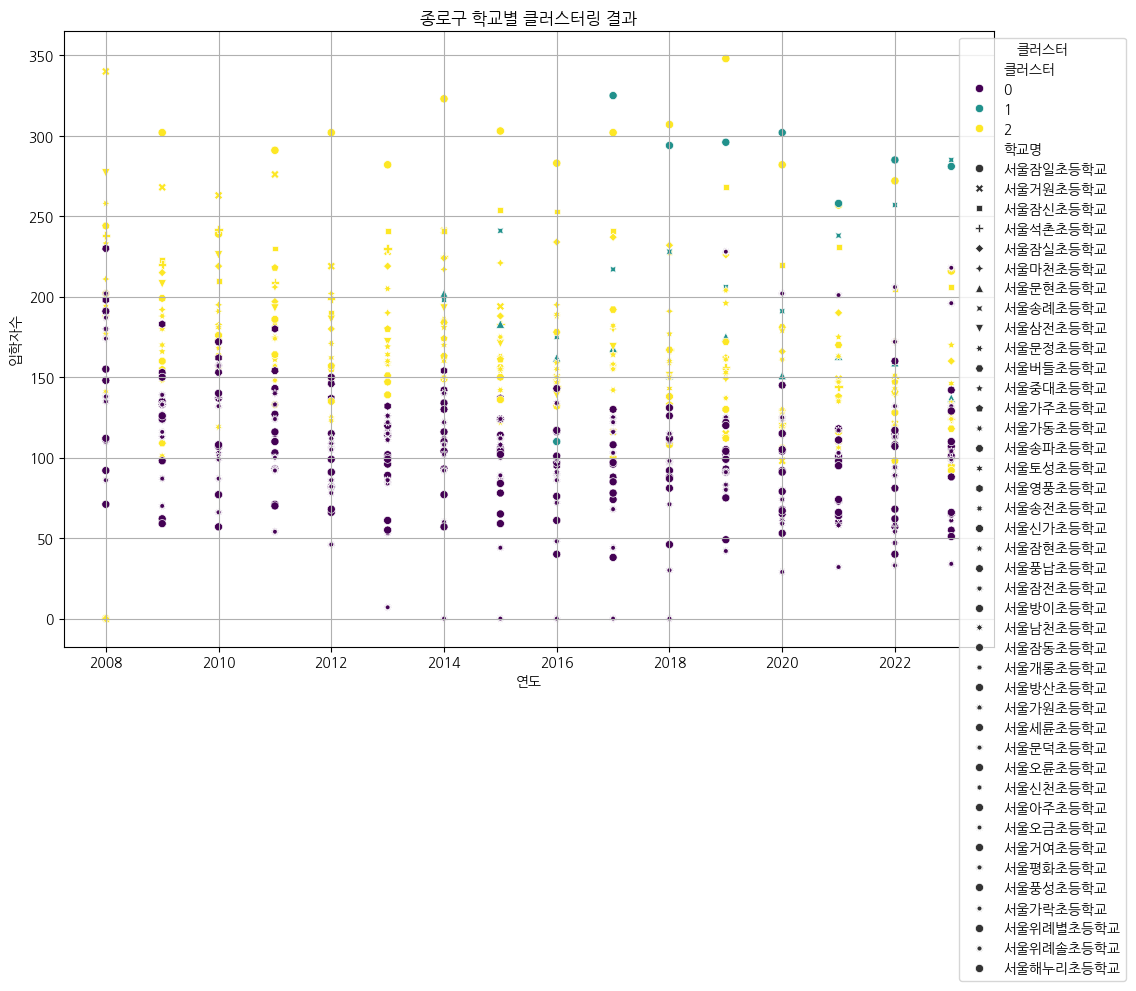

In [ ]:
# 클러스터링
gangnam = data_long[data_long['자치구'] == '송파구']
X = gangnam.pivot_table(index='학교명', columns='연도', values='입학자수', fill_value=0)

# KMeans 클러스터링
kmeans = KMeans(n_clusters=3, random_state=0).fit(X)
cluster_labels = pd.Series(kmeans.labels_, index=X.index)

# 각 학교명에 대해 클러스터 라벨 매핑
gangnam = gangnam.set_index('학교명')
gangnam['클러스터'] = cluster_labels[gangnam.index].values

# 클러스터 시각화
plt.figure(figsize=(12, 8))
sns.scatterplot(x='연도', y='입학자수', hue='클러스터', data=gangnam.reset_index(), palette='viridis', style='학교명', markers=True)
plt.title('종로구 학교별 클러스터링 결과')
plt.xlabel('연도')
plt.ylabel('입학자수')
plt.legend(title='클러스터', loc='upper right', bbox_to_anchor=(1.15, 1))
plt.grid(True)
plt.show()
